<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture2/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN

## Convolutional Layerのスクラッチ実装

In [1]:
# googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Deep_Learning/DL_Lecture2

/content/drive/MyDrive/Deep_Learning/DL_Lecture2


In [3]:
import time

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import utils

In [4]:
# MNISTの画像を使用
dataset = torchvision.datasets.MNIST(root="./mnist_data", train=True, download=True)
image, label = dataset[0]
image = transforms.ToTensor()(image)[0, :, :]

In [5]:
image.shape

torch.Size([28, 28])

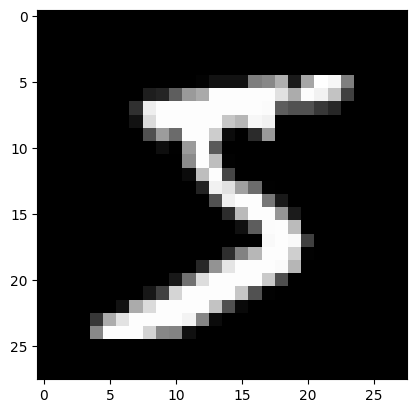

In [6]:
# MNISTの画像を　描画
plt.imshow(image, cmap="gray")

In [7]:
# フィルタの作成(　　3✖️3.  ->  上エッジ　　). -------> 上側をハイライトにしてエッジを検出することが目的
top_edge_filter = torch.tensor([[-1, -1, -1],
                                [0, 0, 0],
                                [1, 1, 1]])

In [8]:
top_edge_filter

tensor([[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]])

In [9]:
import pandas as pd
df = pd.DataFrame(image)
df.style.format(precision=2).set_properties(**{'font-size': '7pt'}).background_gradient('Greys_r')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.07,0.07,0.07,0.49,0.53,0.69,0.10,0.65,1.00,0.97,0.50,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.14,0.37,0.60,0.67,0.99,0.99,0.99,0.99,0.99,0.88,0.67,0.99,0.95,0.76,0.25,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.93,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.36,0.32,0.32,0.22,0.15,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.86,0.99,0.99,0.99,0.99,0.99,0.78,0.71,0.97,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.61,0.42,0.99,0.99,0.80,0.04,0.00,0.17,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [10]:
def apply_filter(image, filter):
    image_hight, image_width = image.shape
    filter_hight, filter_width = filter.shape
    output_data = []
    for i in range(image_hight - filter_hight + 1):
        row = []
        for j in range(image_width - filter_width + 1):
            # 畳み込み演算
            row.append((image[ i : i + filter_hight, j : j + filter_width] * filter).sum().item())
        output_data.append(row)
    return torch.tensor(output_data)

In [11]:
filtered_image = apply_filter(image, top_edge_filter)
filtered_image.shape

torch.Size([26, 26])

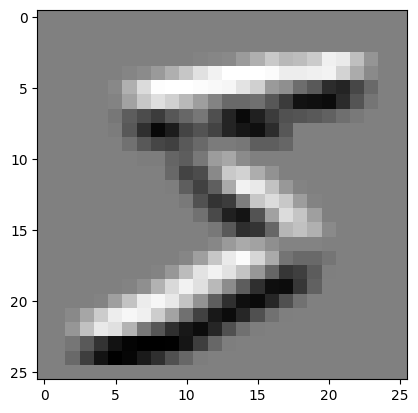

In [12]:
# 畳み込みの処理後
plt.imshow(filtered_image, cmap='gray')

In [13]:
df = pd.DataFrame(filtered_image)
df.style.format(precision=2).set_properties(**{'font-size': '7pt'}).background_gradient('Greys_r')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.08,0.15,0.21,0.64,1.10,1.71,1.32,1.44,1.75,2.62,2.47,1.47,0.50,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.26,0.63,1.11,1.64,2.26,2.65,2.98,2.98,2.98,2.87,2.55,2.55,2.62,2.71,1.96,1.02,0.25,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.19,1.13,2.12,2.92,2.98,2.96,2.89,2.82,2.76,2.34,1.87,0.63,0.35,-0.43,-0.89,-1.93,-2.09,-1.31,-0.50,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.07,0.81,1.66,2.22,1.86,1.34,0.71,0.11,-0.49,-0.52,-0.35,-0.95,-1.60,-2.55,-2.62,-2.71,-1.96,-1.02,-0.25,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,-0.19,-0.81,-1.19,-1.57,-0.95,-0.57,-0.19,-1.14,-2.13,-2.76,-2.20,-1.57,-1.07,-1.01,-0.86,-0.69,-0.37,-0.15,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,-0.07,-0.93,-1.87,-2.78,-2.31,-1.38,-1.03,-1.42,-2.13,-2.46,-2.63,-1.91,-0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,-0.31,-0.93,-1.35,-1.48,-0.87,-0.51,-0.09,-0.09,-0.20,-0.77,-0.77,-0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


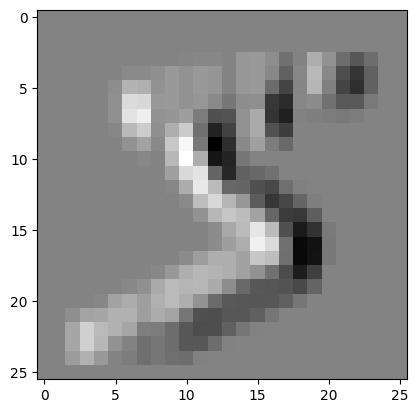

In [14]:
left_edge_filter = torch.tensor([[-1, 0, 1],
                                [-1, 0, 1],
                                [-1, 0, 1]])
filtered_im = apply_filter(image, left_edge_filter)
plt.imshow(filtered_im, cmap='gray')

### CNN構築

In [16]:
# Conv Layer
conv_layer = nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1)
list(conv_layer.parameters())

[Parameter containing:
 tensor([[[[ 0.2251, -0.1808,  0.0565],
           [-0.1616,  0.3177,  0.2786],
           [-0.2380, -0.0830, -0.0428]]],
 
 
         [[[-0.1876, -0.0126,  0.0771],
           [ 0.0789, -0.0871, -0.0180],
           [-0.2049,  0.2088, -0.2729]]],
 
 
         [[[-0.2593, -0.1790,  0.2339],
           [ 0.1390,  0.0601,  0.1423],
           [ 0.3128,  0.2698, -0.0556]]],
 
 
         [[[-0.0790, -0.0492,  0.2961],
           [ 0.2386,  0.2412,  0.0820],
           [-0.3270,  0.2564,  0.1638]]]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1495, -0.2880,  0.1931,  0.3258], requires_grad=True)]

In [18]:
# CNN
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8,16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16,32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2
    nn.Flatten(),
    nn.Linear(32*2*2, 10)
)

In [19]:
conv_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [20]:
# モデルのパラメータ数
torch.tensor([params.numel() for params in conv_model.parameters()]).sum()

tensor(7434)

In [21]:
# サンプルのテンサーで順伝搬し，outputの形状を確認
X = torch.randn((8, 1, 28, 28))
output = conv_model(X)
output.shape

torch.Size([8, 10])

### CNN学習

In [22]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST('./mnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('./mnist_data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4)
X_train, y_train = next(iter(train_loader))
X_train.shape

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 1, 28, 28])

In [23]:
# ラベルには数字が入っている
y_train[:10]

tensor([2, 9, 3, 5, 6, 9, 4, 4, 8, 1])

In [24]:
opt = optim.SGD(conv_model.parameters(), lr=0.03, )
start = time.time()
# 学習
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=5)
end = time.time()
print(end - start)

epoch: 0: train error: 2.3003716301053827, validation error: 2.2960767504535142, validation accuracy: 0.11362737341772151


epoch: 1: train error: 2.256297619612232, validation error: 1.8861616487744488, validation accuracy: 0.4189082278481013


epoch: 2: train error: 0.6309583454307462, validation error: 0.3933854868894891, validation accuracy: 0.8761867088607594


epoch: 3: train error: 0.28034879356177883, validation error: 0.3119335949798174, validation accuracy: 0.8993275316455697


epoch: 4: train error: 0.20958196033419832, validation error: 0.1728121903312357, validation accuracy: 0.9473892405063291
122.12979507446289


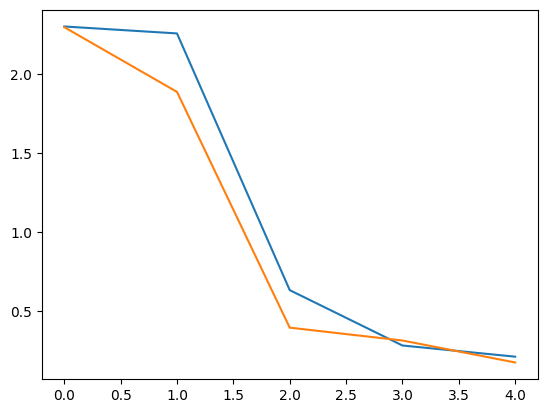

In [25]:
plt.plot(train_losses)
plt.plot(val_losses)